Train KAN[2,1,2] with fixed input activations by linear function.

In [ ]:
# Choose dataset to train/plot
# ASCADf | ASCADv
ds = 'ASCADv'

----- Program codes ----

In [1]:
import torch
from pathlib import Path
import os
import hydra
import numpy as np
import matplotlib.pyplot as plt
import pickle

os.chdir('/workspace')
import src

In [2]:
if ds == 'ASCADf':
    pt = "[[156, 157, 1],[517, 518, 1]]"
elif ds == 'ASCADv':
    pt = "[[188, 189, 1],[1071, 1072, 1]]"

In [3]:
with hydra.initialize(config_path="../../conf", version_base='1.1'):
    cfg = hydra.compose(
        config_name='config',
        overrides=[
            "model=KAN1h",
            "model.model.width.1=1",
            "model.model.grid=17",
            "model.model.k=3",
            "model.train_params.steps=3000",
            f"dataset@train={ds}_profiling",
            f"dataset@test={ds}_attack",
            "trace_transforms=set_poi",
            f"trace_transforms.transforms.0.pois={pt}",
            "trace_transforms.output_size=2",
            "label_transforms=bit",
            "label_transforms.transforms.3.pos=0",
            f"save_path=/workspace/results/ascad/KAN_{ds}_snr/0",
            "n_attack_traces=2000"
            ]
        )

In [4]:
device = hydra.utils.instantiate(cfg.device)
cpu = torch.device('cpu')

Setup dataset

In [5]:
profiling_dataset = hydra.utils.instantiate(cfg.train.dataset)
test_dataset = hydra.utils.instantiate(cfg.test.dataset)

train_dataloader = torch.utils.data.DataLoader(
    profiling_dataset, batch_size=cfg.train.batch_size, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=cfg.test.batch_size, shuffle=False
)
KANds = src.utils.to_KAN_dataset(
    train_dataloader, test_dataloader,
    device=device)

Train KAN

In [6]:
model = hydra.utils.instantiate(cfg.model.model)
model = model.to(device)

Set symbolic functions

In [12]:
model(KANds['test_input'][:10000])
model.fix_symbolic(0,0,0, 'x')
model.fix_symbolic(0,1,0, 'x')

r2 is 0.7831887006759644
r2 is not very high, please double check if you are choosing the correct symbolic function.
r2 is 0.5707773566246033
r2 is not very high, please double check if you are choosing the correct symbolic function.


tensor(0.5708, device='cuda:0')

Fine-tuning

In [13]:
_ = model.train(
    KANds,
    **hydra.utils.instantiate(cfg.model.train_params)
    )

train loss: 8.34e-01 | test loss: 8.31e-01 | reg: 4.55e-01 : 100%|█| 3000/3000 [01:57<00:00, 25.57it


Evaluate

In [14]:
preds, labels, th = src.utils.make_prediction(
    model, test_dataloader, device)

preds_class = np.argmax(preds, axis=1)
accuracy = np.mean(labels == preds_class)
print('Accuracy: ', accuracy)

Accuracy:  0.55337


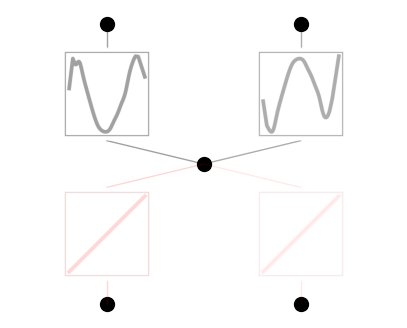

In [15]:
model(KANds['train_input'][:10000])
model.plot(folder=cfg.save_path+'/fixed')
plt.savefig(
    Path(cfg.save_path, f'{cfg.model.name}_fixed.png'),
    dpi=300, bbox_inches=0)
src.utils.plot_KAN(cfg, model, 'fixed')

In [16]:
correct_key = test_dataset.key[0][cfg.target_byte]
key_hyposesis = range(256)
if not Path(cfg.save_path, 'label_hyposesis.npy').exists():
    label_hyposesis = src.utils.make_label_hyposesis(
        test_dataset, key_hyposesis)
    np.save(Path(cfg.save_path, 'label_hyposesis.npy'), label_hyposesis)
label_hyposesis = np.load(Path(cfg.save_path, 'label_hyposesis.npy'))

ge = src.sca_utils.calc_guessing_entropy(
    preds, label_hyposesis, correct_key,
    cfg.n_attack_traces, n_trial=cfg.n_trials)
print(np.where(ge==0)[0])

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ge)
fig.savefig(Path(cfg.save_path, f'{cfg.model.name}_grid17.png'), dpi=300, bbox_inches=0)